<a href="https://colab.research.google.com/github/gitjisoo/DATATHON_4/blob/main/%EA%B9%80%EC%A7%80%EC%88%98/%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%86%A4_4%ED%8C%80_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_12%EA%B0%9C%EC%9B%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl
import seaborn as sns
import matplotlib.patches as patches

In [ ]:
import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
#한글 글씨 폰트 설치
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

mpl.rcParams['figure.autolayout'] = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/shinhan/전처리완료_정렬.csv')

In [ ]:
df["기준년월_dt"] = pd.to_datetime(df["기준년월_dt"], errors="coerce")
df["기준년월_dt"] = df["기준년월_dt"].dt.to_period("M").dt.to_timestamp()

In [ ]:
STORE = "가맹점구분번호"
DATE  = "기준년월_dt"
TARGETS = [
    "신규고객_비중_cleaned",
    "재방문고객_비중_cleaned",
    "유동인구고객_비중_cleaned"
]

In [ ]:
# 타깃 유효값 필터링
for c in TARGETS:
    if c not in df.columns:
        raise ValueError(f"'{c}' 컬럼이 데이터에 없습니다.")
df = df[
    df[TARGETS].notna().all(axis=1) &
    (df[TARGETS] >= 0).all(axis=1)
]

if STORE not in df.columns:
    raise ValueError(f"{STORE} 컬럼을 찾지 못했습니다.")

df = df.sort_values([STORE, DATE]).reset_index(drop=True)

print(f"데이터 로드 완료: {df.shape}")
print(f"기간: {df[DATE].min()} ~ {df[DATE].max()}")
print(f"가맹점 수: {df[STORE].nunique()}")
print(f"타깃: {TARGETS}")

데이터 로드 완료: (80705, 5)
기간: 2023-01-01 00:00:00 ~ 2024-12-01 00:00:00
가맹점 수: 3913
타깃: ['신규고객_비중_cleaned', '재방문고객_비중_cleaned', '유동인구고객_비중_cleaned']


In [ ]:
WINDOW = 12
HORIZON = 1
MIN_SAMPLES = 500

# Lag feature 생성

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

MA_WINDOWS = [3, 6, 12]  # 이동평균 k

# ===================== 평가 지표 함수 =====================
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred)
    num = 2.0 * np.abs(y_pred - y_true)
    # 둘 다 0인 경우는 0으로 처리
    return 100.0 * np.mean(np.where(denom == 0, 0, num / (denom + 1e-8)))

def mase(y_true, y_pred, y_naive):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    y_naive = np.asarray(y_naive, dtype=float)
    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true - y_naive))
    if mae_naive == 0:
        return np.nan
    return mae_model / mae_naive

# ===================== 베이스라인용 Lag & 이동평균 생성 =====================
df = df.sort_values([STORE, DATE]).reset_index(drop=True)

for t in TARGETS:
    g = df.groupby(STORE)[t]
    df[f"{t}_lag1"]  = g.shift(1)
    df[f"{t}_lag12"] = g.shift(12)
    for k in MA_WINDOWS:
        df[f"{t}_ma{k}"] = g.shift(1).rolling(k).mean()

# Lag1~3 모델용 추가 lag (2,3)
for lag in [2, 3]:
    for t in TARGETS:
        df[f"{t}_lag{lag}"] = df.groupby(STORE)[t].shift(lag)

all_months = np.sort(df[DATE].unique())


In [ ]:
# ===================== Lag1 모델 설정 =====================
def make_xgb_lag1():
    return XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=10,
        reg_lambda=6.0,
        reg_alpha=2.0,
        gamma=0.3,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

lag1_features = {t: [f"{t}_lag1"] for t in TARGETS}

results_lag1 = []        # (test_month, target) 단위 성능 기록
pred_lag1_records = []   # (test_month, target) 단위 실제/예측 평균값 기록

for i in range(WINDOW, len(all_months) - HORIZON + 1):
    train_months = all_months[i - WINDOW : i]
    test_month   = all_months[i + HORIZON - 1]

    base_train = df[df[DATE].isin(train_months)].copy()
    base_test  = df[df[DATE] == test_month].copy()

    for t in TARGETS:
        cols_needed = [t, f"{t}_lag1", f"{t}_lag12"] + [f"{t}_ma{k}" for k in MA_WINDOWS]

        train_t = base_train.dropna(subset=cols_needed)
        test_t  = base_test.dropna(subset=cols_needed)

        if (len(train_t) < MIN_SAMPLES) or (len(test_t) == 0):
            continue

        # ===== XGB (Lag1만 사용) =====
        X_train = train_t[[f"{t}_lag1"]]
        y_train = train_t[t]
        X_test  = test_t[[f"{t}_lag1"]]
        y_test  = test_t[t].values

        model = make_xgb_lag1()
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)

        # ===== Baseline 예측 =====
        y_naive1 = test_t[f"{t}_lag1"].values
        y_seasonal = test_t[f"{t}_lag12"].values
        ma_preds = {k: test_t[f"{t}_ma{k}"].values for k in MA_WINDOWS}

        # ===== 공통 Naive MAE (MASE 기준) =====
        mae_naive1 = mean_absolute_error(y_test, y_naive1) if len(y_naive1) > 0 else np.nan

        # ===== 모델 & 베이스라인 지표 계산 =====
        mae_model = mean_absolute_error(y_test, y_hat)
        r2_model  = r2_score(y_test, y_hat)
        smape_model = smape(y_test, y_hat)
        mase_model  = mase(y_test, y_hat, y_naive1) if not np.isnan(mae_naive1) else np.nan

        smape_naive1 = smape(y_test, y_naive1)
        def safe_metric(yb, func):
            mask = ~np.isnan(y_test) & ~np.isnan(yb)
            return func(y_test[mask], yb[mask]) if mask.sum() > 0 else np.nan

        mae_seasonal  = safe_metric(y_seasonal, mean_absolute_error)
        smape_seasonal = safe_metric(y_seasonal, smape)
        mase_seasonal  = (mae_seasonal / mae_naive1) if (mae_naive1 not in [0, np.nan]) else np.nan

        mae_ma = {}
        smape_ma = {}
        mase_ma = {}
        for k in MA_WINDOWS:
            mae_ma[k]    = safe_metric(ma_preds[k], mean_absolute_error)
            smape_ma[k]  = safe_metric(ma_preds[k], smape)
            mase_ma[k]   = (mae_ma[k] / mae_naive1) if (mae_naive1 not in [0, np.nan]) else np.nan

        # ===== 결과 저장 (test_month & target 단위) =====
        rec = {
            "model_type": "Lag1",
            "test_month": test_month,
            "target": t,
            "MAE_model": mae_model,
            "R2_model": r2_model,
            "sMAPE_model": smape_model,
            "MASE_model": mase_model,
            "MAE_naive1": mae_naive1,
            "sMAPE_naive1": smape_naive1,
            "MASE_naive1": 1.0,  # naive1 기준
            "MAE_seasonal12": mae_seasonal,
            "sMAPE_seasonal12": smape_seasonal,
            "MASE_seasonal12": mase_seasonal,
        }
        for k in MA_WINDOWS:
            rec[f"MAE_ma{k}"]   = mae_ma[k]
            rec[f"sMAPE_ma{k}"] = smape_ma[k]
            rec[f"MASE_ma{k}"]  = mase_ma[k]
        results_lag1.append(rec)

        pred_rec = {
            "model_type": "Lag1",
            "test_month": test_month,
            "target": t,
            "actual_mean": y_test.mean(),
            "model_pred_mean": y_hat.mean(),
            "naive1_mean": y_naive1.mean(),
            "seasonal12_mean": np.nanmean(y_seasonal),
        }
        for k in MA_WINDOWS:
            pred_rec[f"ma{k}_mean"] = np.nanmean(ma_preds[k])
        pred_lag1_records.append(pred_rec)

results_lag1_df = pd.DataFrame(results_lag1)
pred_lag1_df = pd.DataFrame(pred_lag1_records)


In [ ]:
print("\n===== Lag1 기반 1개월 후 비중 예측 (롤링 윈도우) =====")
display(HTML(results_lag1_df.tail(10).to_html(index=False, border=1, justify="center")))


===== Lag1 기반 1개월 후 비중 예측 (롤링 윈도우) =====


model_type,test_month,target,MAE_model,R2_model,sMAPE_model,MASE_model,MAE_naive1,sMAPE_naive1,MASE_naive1,MAE_seasonal12,sMAPE_seasonal12,MASE_seasonal12,MAE_ma3,sMAPE_ma3,MASE_ma3,MAE_ma6,sMAPE_ma6,MASE_ma6,MAE_ma12,sMAPE_ma12,MASE_ma12
Lag1,2024-09-01,유동인구고객_비중_cleaned,11.296249,0.551066,34.281479,1.092864,10.336369,26.574631,1.0,12.524089,32.598076,1.211653,9.141457,25.515147,0.884397,9.041876,27.225344,0.874763,9.551895,29.906349,0.924105
Lag1,2024-10-01,신규고객_비중_cleaned,2.359276,0.011639,38.077940,0.851523,2.770654,38.205949,1.0,5.952258,50.088584,2.148322,2.557748,37.726600,0.923157,2.345552,36.431403,0.846570,2.813633,39.974721,1.015512
Lag1,2024-10-01,재방문고객_비중_cleaned,1.212166,0.955814,5.932638,1.066004,1.137112,5.098677,1.0,4.318455,20.258581,3.797739,1.507901,7.046077,1.326079,1.925105,8.864141,1.692977,2.545634,11.669481,2.238683
Lag1,2024-10-01,유동인구고객_비중_cleaned,11.248518,0.539387,33.898586,1.068784,10.524597,26.537048,1.0,12.672053,32.815726,1.204042,9.495068,26.497018,0.902179,9.295549,28.072302,0.883221,9.559496,29.957205,0.908300
Lag1,2024-11-01,신규고객_비중_cleaned,2.134879,0.103997,36.188948,0.871518,2.449610,34.321933,1.0,5.764899,50.161341,2.353395,2.310766,34.588507,0.943320,2.434797,37.276280,0.993953,2.928754,40.950097,1.195600
Lag1,2024-11-01,재방문고객_비중_cleaned,1.299742,0.941102,6.626672,1.055255,1.231685,5.974744,1.0,4.416118,21.762416,3.585428,1.586436,7.748301,1.288021,1.992975,9.576741,1.618089,2.584448,12.248912,2.098303
Lag1,2024-11-01,유동인구고객_비중_cleaned,10.832140,0.556247,33.402012,1.065361,10.167581,25.296610,1.0,13.335527,34.632987,1.311573,8.989326,25.108553,0.884116,8.952686,27.024438,0.880513,9.338881,29.450278,0.918496
Lag1,2024-12-01,신규고객_비중_cleaned,2.352951,0.141230,40.379803,0.961544,2.447054,35.185269,1.0,5.674657,48.390144,2.318975,2.397374,36.633366,0.979698,2.540922,39.999774,1.038359,3.064588,44.262627,1.252358
Lag1,2024-12-01,재방문고객_비중_cleaned,1.280618,0.953230,7.147271,1.048988,1.220813,5.924753,1.0,4.317774,21.603230,3.536801,1.603687,8.136333,1.313622,2.014770,10.205540,1.650351,2.625244,12.970590,2.150406
Lag1,2024-12-01,유동인구고객_비중_cleaned,11.182086,0.540661,34.017519,1.071610,10.434849,25.840284,1.0,12.718916,33.247925,1.218888,9.213494,25.124131,0.882954,9.084864,26.907523,0.870627,9.374350,29.840768,0.898369


In [ ]:
# ===================== Lag1~3 모델 설정 =====================
def make_xgb_lag123():
    return XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=10,
        reg_lambda=6.0,
        reg_alpha=2.0,
        gamma=0.3,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

lag123_features = {t: [f"{t}_lag1", f"{t}_lag2", f"{t}_lag3"] for t in TARGETS}

results_lag123 = []
pred_lag123_records = []

for i in range(WINDOW, len(all_months) - HORIZON + 1):
    train_months = all_months[i - WINDOW : i]
    test_month   = all_months[i + HORIZON - 1]

    base_train = df[df[DATE].isin(train_months)].copy()
    base_test  = df[df[DATE] == test_month].copy()

    for t in TARGETS:
        cols_needed = (
            [t] +
            lag123_features[t] +
            [f"{t}_lag1", f"{t}_lag12"] +
            [f"{t}_ma{k}" for k in MA_WINDOWS]
        )

        train_t = base_train.dropna(subset=cols_needed)
        test_t  = base_test.dropna(subset=cols_needed)

        if (len(train_t) < MIN_SAMPLES) or (len(test_t) == 0):
            continue

        # ===== XGB (Lag1~3 사용) =====
        X_train = train_t[lag123_features[t]]
        y_train = train_t[t]
        X_test  = test_t[lag123_features[t]]
        y_test  = test_t[t].values

        model = make_xgb_lag123()
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)

        # ===== Baseline 예측 =====
        y_naive1 = test_t[f"{t}_lag1"].values
        y_seasonal = test_t[f"{t}_lag12"].values
        ma_preds = {k: test_t[f"{t}_ma{k}"].values for k in MA_WINDOWS}

        mae_naive1 = mean_absolute_error(y_test, y_naive1) if len(y_naive1) > 0 else np.nan

        mae_model = mean_absolute_error(y_test, y_hat)
        r2_model  = r2_score(y_test, y_hat)
        smape_model = smape(y_test, y_hat)
        mase_model  = mase(y_test, y_hat, y_naive1) if not np.isnan(mae_naive1) else np.nan

        smape_naive1 = smape(y_test, y_naive1)

        def safe_metric(yb, func):
            mask = ~np.isnan(y_test) & ~np.isnan(yb)
            return func(y_test[mask], yb[mask]) if mask.sum() > 0 else np.nan

        mae_seasonal  = safe_metric(y_seasonal, mean_absolute_error)
        smape_seasonal = safe_metric(y_seasonal, smape)
        mase_seasonal  = (mae_seasonal / mae_naive1) if (mae_naive1 not in [0, np.nan]) else np.nan

        mae_ma = {}
        smape_ma = {}
        mase_ma = {}
        for k in MA_WINDOWS:
            mae_ma[k]    = safe_metric(ma_preds[k], mean_absolute_error)
            smape_ma[k]  = safe_metric(ma_preds[k], smape)
            mase_ma[k]   = (mae_ma[k] / mae_naive1) if (mae_naive1 not in [0, np.nan]) else np.nan

        rec = {
            "model_type": "Lag1~3",
            "test_month": test_month,
            "target": t,
            "MAE_model": mae_model,
            "R2_model": r2_model,
            "sMAPE_model": smape_model,
            "MASE_model": mase_model,
            "MAE_naive1": mae_naive1,
            "sMAPE_naive1": smape_naive1,
            "MASE_naive1": 1.0,
            "MAE_seasonal12": mae_seasonal,
            "sMAPE_seasonal12": smape_seasonal,
            "MASE_seasonal12": mase_seasonal,
        }
        for k in MA_WINDOWS:
            rec[f"MAE_ma{k}"]   = mae_ma[k]
            rec[f"sMAPE_ma{k}"] = smape_ma[k]
            rec[f"MASE_ma{k}"]  = mase_ma[k]
        results_lag123.append(rec)

        pred_rec = {
            "model_type": "Lag1~3",
            "test_month": test_month,
            "target": t,
            "actual_mean": y_test.mean(),
            "model_pred_mean": y_hat.mean(),
            "naive1_mean": y_naive1.mean(),
            "seasonal12_mean": np.nanmean(y_seasonal),
        }
        for k in MA_WINDOWS:
            pred_rec[f"ma{k}_mean"] = np.nanmean(ma_preds[k])
        pred_lag123_records.append(pred_rec)

results_lag123_df = pd.DataFrame(results_lag123)
pred_lag123_df = pd.DataFrame(pred_lag123_records)


In [ ]:
from IPython.display import display, HTML

print("\n===== Lag1~3 기반 1개월 후 비중 예측 (롤링 윈도우) =====")
display(HTML(results_lag123_df.tail(10).to_html(index=False, border=1, justify="center")))


===== Lag1~3 기반 1개월 후 비중 예측 (롤링 윈도우) =====


model_type,test_month,target,MAE_model,R2_model,sMAPE_model,MASE_model,MAE_naive1,sMAPE_naive1,MASE_naive1,MAE_seasonal12,sMAPE_seasonal12,MASE_seasonal12,MAE_ma3,sMAPE_ma3,MASE_ma3,MAE_ma6,sMAPE_ma6,MASE_ma6,MAE_ma12,sMAPE_ma12,MASE_ma12
Lag1~3,2024-09-01,유동인구고객_비중_cleaned,9.793846,0.622000,31.800482,0.947513,10.336369,26.574631,1.0,12.524089,32.598076,1.211653,9.141457,25.515147,0.884397,9.041876,27.225344,0.874763,9.551895,29.906349,0.924105
Lag1~3,2024-10-01,신규고객_비중_cleaned,2.336838,0.032893,38.403559,0.843424,2.770654,38.205949,1.0,5.952258,50.088584,2.148322,2.557748,37.726600,0.923157,2.345552,36.431403,0.846570,2.813633,39.974721,1.015512
Lag1~3,2024-10-01,재방문고객_비중_cleaned,1.270064,0.953229,6.164621,1.116921,1.137112,5.098677,1.0,4.318455,20.258581,3.797739,1.507901,7.046077,1.326079,1.925105,8.864141,1.692977,2.545634,11.669481,2.238683
Lag1~3,2024-10-01,유동인구고객_비중_cleaned,10.014457,0.612166,32.090392,0.951529,10.524597,26.537048,1.0,12.672053,32.815726,1.204042,9.495068,26.497018,0.902179,9.295549,28.072302,0.883221,9.559496,29.957205,0.908300
Lag1~3,2024-11-01,신규고객_비중_cleaned,2.119385,0.092481,36.223972,0.865193,2.449610,34.321933,1.0,5.764899,50.161341,2.353395,2.310766,34.588507,0.943320,2.434797,37.276280,0.993953,2.928754,40.950097,1.195600
Lag1~3,2024-11-01,재방문고객_비중_cleaned,1.339830,0.940743,6.839284,1.087802,1.231685,5.974744,1.0,4.416118,21.762416,3.585428,1.586436,7.748301,1.288021,1.992975,9.576741,1.618089,2.584448,12.248912,2.098303
Lag1~3,2024-11-01,유동인구고객_비중_cleaned,9.484353,0.623669,31.209140,0.932803,10.167581,25.296610,1.0,13.335527,34.632987,1.311573,8.989326,25.108553,0.884116,8.952686,27.024438,0.880513,9.338881,29.450278,0.918496
Lag1~3,2024-12-01,신규고객_비중_cleaned,2.335488,0.149302,40.339847,0.954408,2.447054,35.185269,1.0,5.674657,48.390144,2.318975,2.397374,36.633366,0.979698,2.540922,39.999774,1.038359,3.064588,44.262627,1.252358
Lag1~3,2024-12-01,재방문고객_비중_cleaned,1.360861,0.948519,7.461646,1.114716,1.220813,5.924753,1.0,4.317774,21.603230,3.536801,1.603687,8.136333,1.313622,2.014770,10.205540,1.650351,2.625244,12.970590,2.150406
Lag1~3,2024-12-01,유동인구고객_비중_cleaned,9.718891,0.613266,31.538785,0.931388,10.434849,25.840284,1.0,12.718916,33.247925,1.218888,9.213494,25.124131,0.882954,9.084864,26.907523,0.870627,9.374350,29.840768,0.898369


In [ ]:
# ===================== 타깃별 평균 성능 요약 (Lag1 / Lag1~3) =====================

def summarize_by_target(results_df, label):
    rows = []
    for t in TARGETS:
        sub = results_df[results_df["target"] == t]
        if len(sub) == 0:
            continue
        rows.append({
            "target": t,
            f"{label}_sMAPE_model": sub["sMAPE_model"].mean(),
            f"{label}_MASE_model":  sub["MASE_model"].mean(),
            "Naive1_sMAPE":         sub["sMAPE_naive1"].mean(),
            "Naive1_MASE":          sub["MASE_naive1"].mean(),
            "Seasonal12_sMAPE":     sub["sMAPE_seasonal12"].mean(),
            "Seasonal12_MASE":      sub["MASE_seasonal12"].mean(),
            "MA3_sMAPE":            sub.get("sMAPE_ma3", pd.Series(dtype=float)).mean(),
            "MA3_MASE":             sub.get("MASE_ma3", pd.Series(dtype=float)).mean(),
            "MA6_sMAPE":            sub.get("sMAPE_ma6", pd.Series(dtype=float)).mean(),
            "MA6_MASE":             sub.get("MASE_ma6", pd.Series(dtype=float)).mean(),
            "MA12_sMAPE":           sub.get("sMAPE_ma12", pd.Series(dtype=float)).mean(),
            "MA12_MASE":            sub.get("MASE_ma12", pd.Series(dtype=float)).mean(),
        })
    out = pd.DataFrame(rows).set_index("target").round(4)
    display(out)
    return out

print("Lag1 모델 기준 타깃별 sMAPE / MASE 요약")
summary_lag1 = summarize_by_target(results_lag1_df, "Lag1")

print("Lag1~3 모델 기준 타깃별 sMAPE / MASE 요약")
summary_lag123 = summarize_by_target(results_lag123_df, "Lag1_3")


Lag1 모델 기준 타깃별 sMAPE / MASE 요약


,Lag1_sMAPE_model,Lag1_MASE_model,Naive1_sMAPE,Naive1_MASE,Seasonal12_sMAPE,Seasonal12_MASE,MA3_sMAPE,MA3_MASE,MA6_sMAPE,MA6_MASE,MA12_sMAPE,MA12_MASE
target,,,,,,,,,,,,
신규고객_비중_cleaned,37.2455,0.9108,35.2424,1.0,48.9592,2.3372,35.8685,0.9701,37.7663,0.9890,41.5165,1.2079
재방문고객_비중_cleaned,5.9395,1.0642,5.3290,1.0,20.1839,3.7006,6.9180,1.2910,8.6938,1.6327,11.4007,2.1660
유동인구고객_비중_cleaned,32.8080,1.0739,25.9405,1.0,32.4153,1.2246,25.9401,0.9043,27.5761,0.8975,28.8740,0.9213


Lag1~3 모델 기준 타깃별 sMAPE / MASE 요약


,Lag1_3_sMAPE_model,Lag1_3_MASE_model,Naive1_sMAPE,Naive1_MASE,Seasonal12_sMAPE,Seasonal12_MASE,MA3_sMAPE,MA3_MASE,MA6_sMAPE,MA6_MASE,MA12_sMAPE,MA12_MASE
target,,,,,,,,,,,,
신규고객_비중_cleaned,37.4189,0.9075,35.2424,1.0,48.9592,2.3372,35.8685,0.9701,37.7663,0.9890,41.5165,1.2079
재방문고객_비중_cleaned,6.1961,1.1174,5.3290,1.0,20.1839,3.7006,6.9180,1.2910,8.6938,1.6327,11.4007,2.1660
유동인구고객_비중_cleaned,30.7659,0.9534,25.9405,1.0,32.4153,1.2246,25.9401,0.9043,27.5761,0.8975,28.8740,0.9213


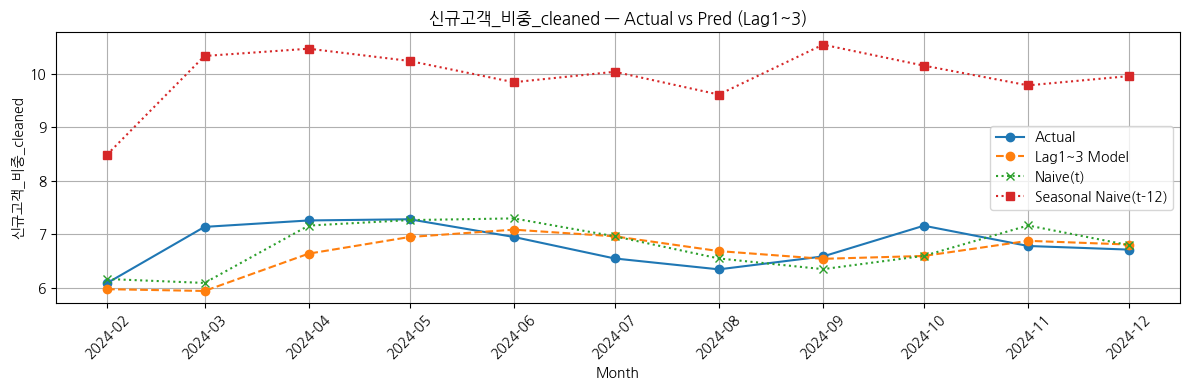

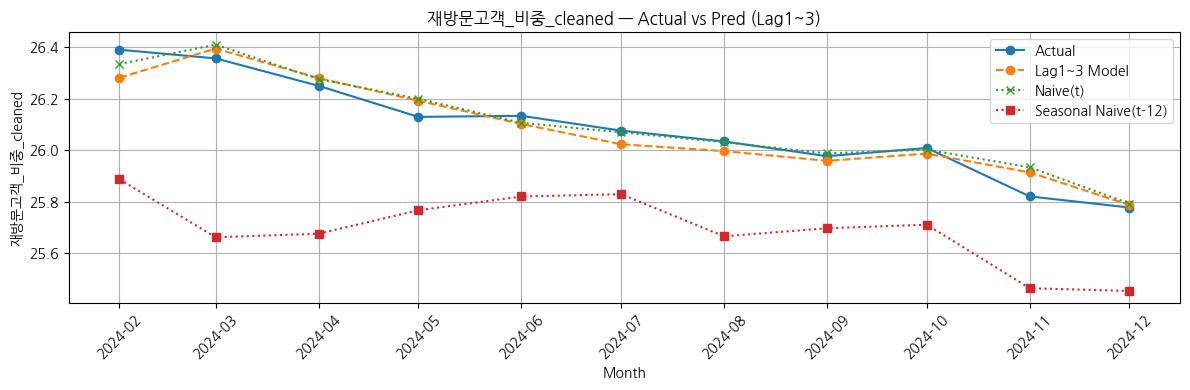

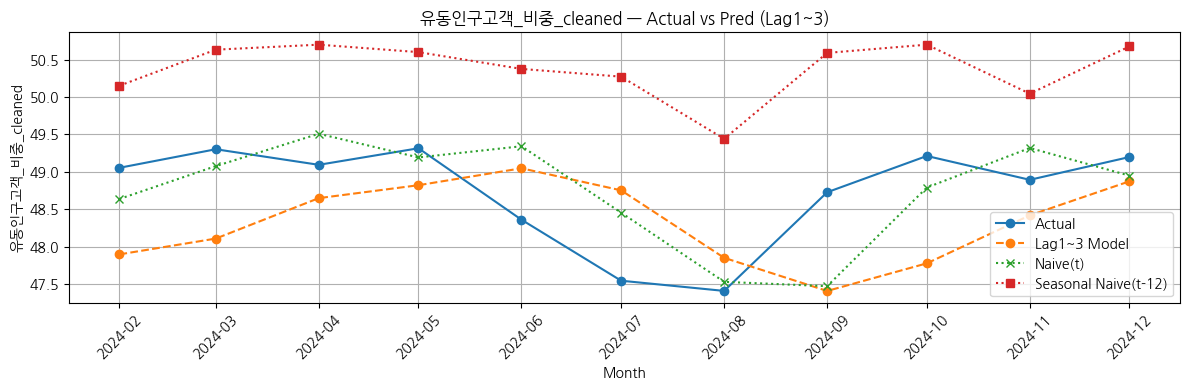

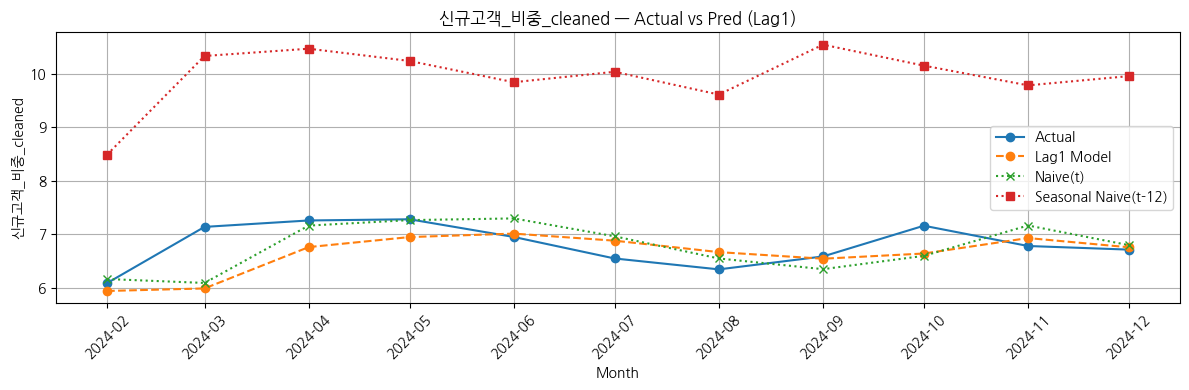

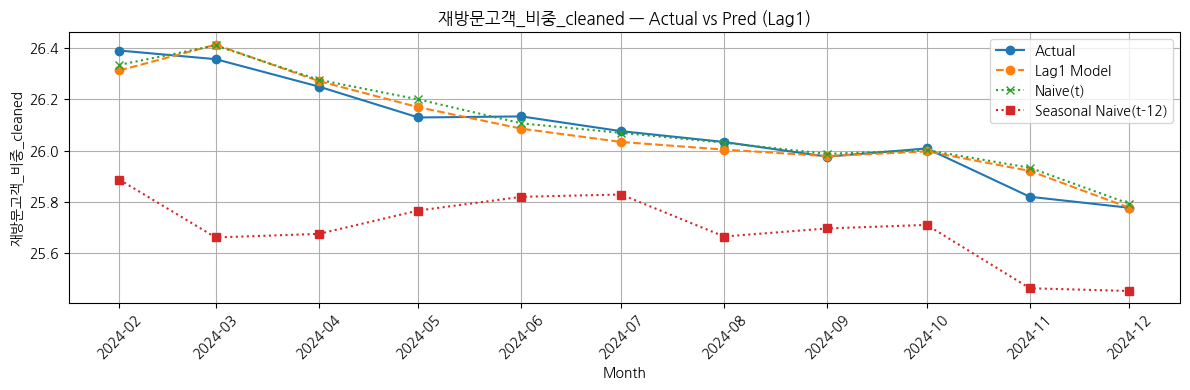

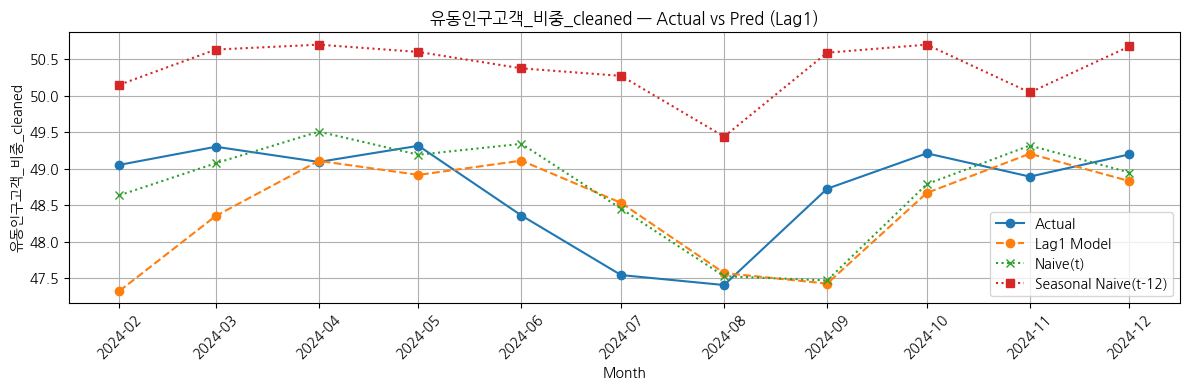

In [ ]:
# ===================== 실제값 vs 예측값 (월평균) 시각화 =====================

def plot_actual_vs_models(pred_df, var_name, title_label):
    sub = pred_df[pred_df["target"] == var_name].sort_values("test_month")
    if sub.empty:
        print(f"{title_label}: {var_name} 데이터 없음")
        return

    plt.figure(figsize=(12,4))
    plt.plot(sub["test_month"], sub["actual_mean"], marker="o", label="Actual")
    plt.plot(sub["test_month"], sub["model_pred_mean"], marker="o", linestyle="--", label=f"{title_label} Model")
    plt.plot(sub["test_month"], sub["naive1_mean"], marker="x", linestyle=":", label="Naive(t)")
    plt.plot(sub["test_month"], sub["seasonal12_mean"], marker="s", linestyle=":", label="Seasonal Naive(t-12)")
    plt.title(f"{var_name} — Actual vs Pred ({title_label})")
    plt.xlabel("Month")
    plt.ylabel(var_name)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Lag1~3 모델 시각화
for t in TARGETS:
    plot_actual_vs_models(pred_lag123_df, t, "Lag1~3")

# Lag1 모델 시각화
for t in TARGETS:
    plot_actual_vs_models(pred_lag1_df, t, "Lag1")


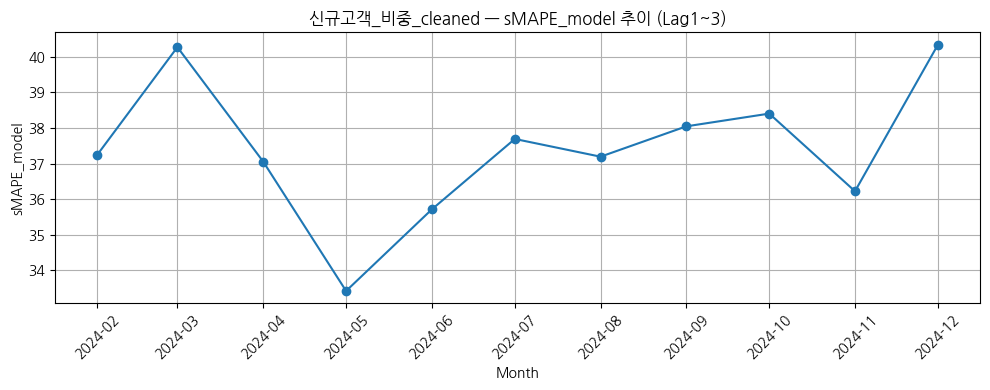

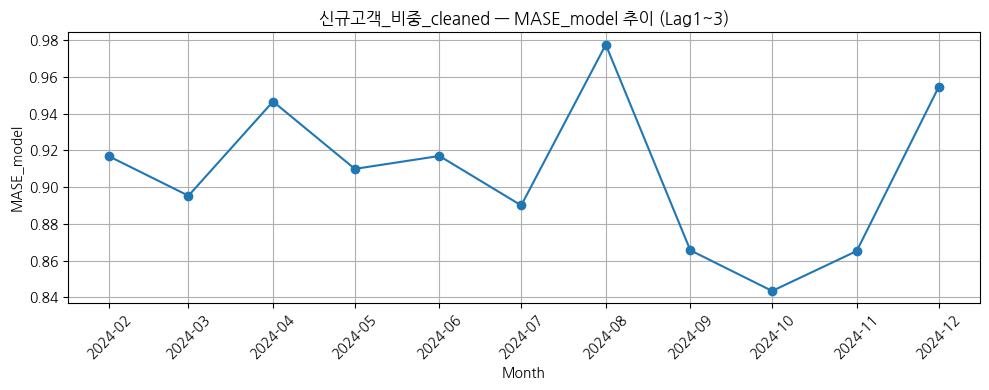

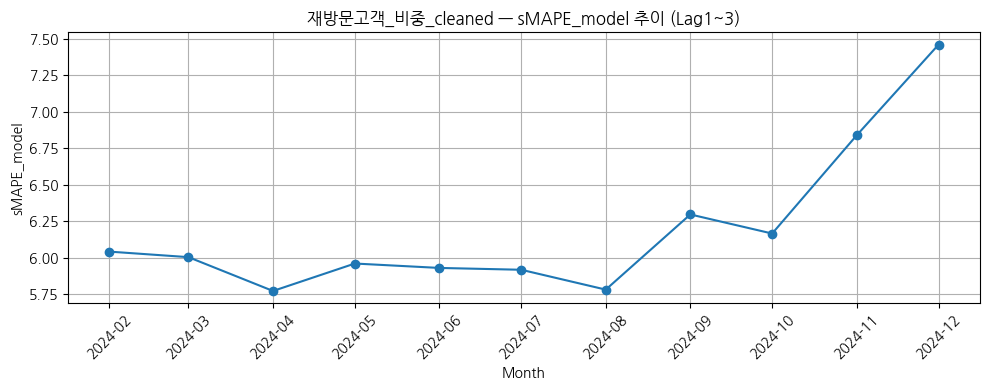

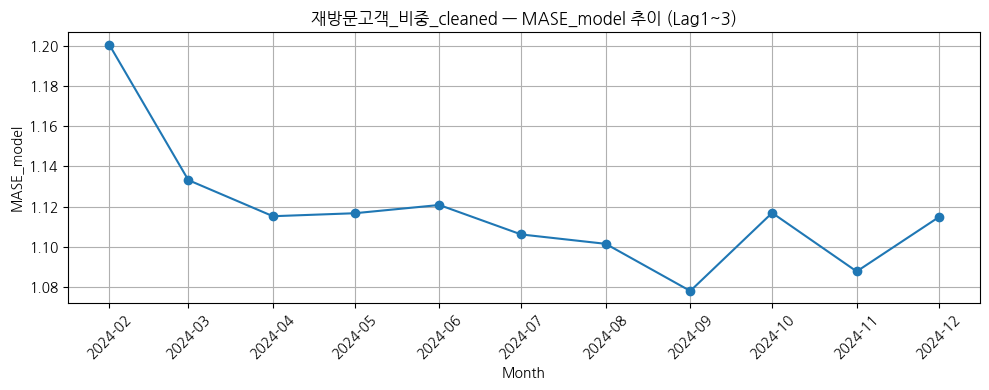

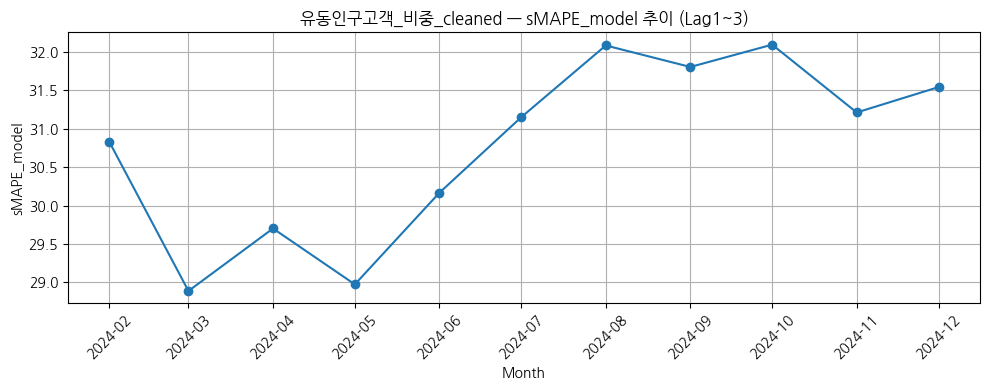

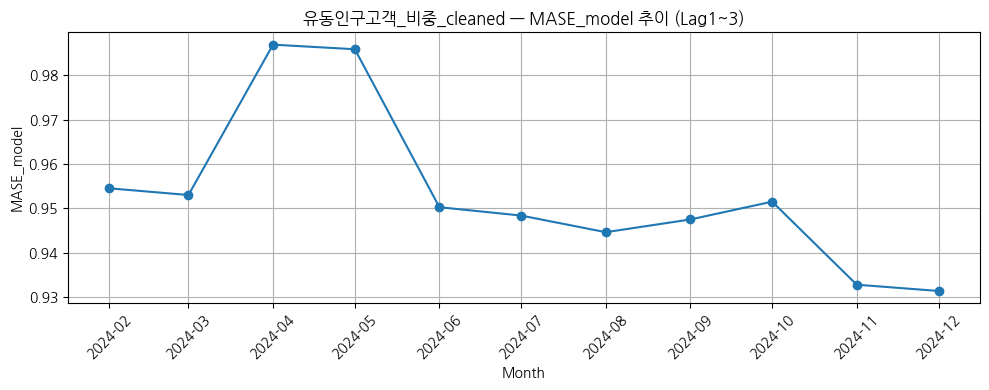

In [ ]:
# ===================== sMAPE / MASE 시계열 추이 (옵션) =====================

def plot_metric_over_time(results_df, var_name, metric_col, title_label):
    sub = results_df[(results_df["target"] == var_name)].sort_values("test_month")
    if sub.empty or metric_col not in sub.columns:
        print(f"{title_label}: {var_name} - {metric_col} 없음")
        return
    plt.figure(figsize=(10,4))
    plt.plot(sub["test_month"], sub[metric_col], marker="o", label=metric_col)
    plt.title(f"{var_name} — {metric_col} 추이 ({title_label})")
    plt.xlabel("Month")
    plt.ylabel(metric_col)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Lag1~3 모델 sMAPE / MASE 추이
for t in TARGETS:
    plot_metric_over_time(results_lag123_df, t, "sMAPE_model", "Lag1~3")
    plot_metric_over_time(results_lag123_df, t, "MASE_model",  "Lag1~3")
